Whole Slide Images (WSI) are captured at a very high resolution. In this dataset, 21 anonymised WSI images in Aperio SVS format, of canine carcinoma, are available. The cell annotations are provided in a SQLite3 database. 

Below we extract the dimensions of all the 21 images from the database. 

In [1]:
from SlideRunner.dataAccess.database import Database
import numpy as np

def listOfSlides(DB):
    DB.execute('SELECT uid, filename, width, height from Slides')
    return DB.fetchall()

DB = Database()
DB.open('databases/MITOS_WSI_CMC_COADEL_TR.sqlite')

for slideid,filename, width, height in listOfSlides(DB):
    print(f"Slide ID# {slideid}: {filename} {height} x {width} pixels")


Slide ID# 1: a8773be388e12df89edd.svs 57462 x 61199 pixels
Slide ID# 2: 460906c0b1fe17ea5354.svs 63831 x 136800 pixels
Slide ID# 3: 2d56d1902ca533a5b509.svs 65453 x 70199 pixels
Slide ID# 5: d0423ef9a648bb66a763.svs 85208 x 116999 pixels
Slide ID# 6: 50cf88e9a33df0c0c8f9.svs 87273 x 125999 pixels
Slide ID# 7: da18e7b9846e9d38034c.svs 84305 x 95399 pixels
Slide ID# 8: d7a8af121d7d4f3fbf01.svs 88592 x 111599 pixels
Slide ID# 9: 2191a7aa287ce1d5dbc0.svs 82534 x 98999 pixels
Slide ID# 10: 69a02453620ade0edefd.svs 90076 x 97199 pixels
Slide ID# 11: c4b95da36e32993289cb.svs 84710 x 124199 pixels
Slide ID# 12: fa4959e484beec77543b.svs 84406 x 118799 pixels
Slide ID# 13: 72c93e042d0171a61012.svs 78623 x 122399 pixels
Slide ID# 14: 4eee7b944ad5e46c60ce.svs 47721 x 44999 pixels
Slide ID# 15: b1bdee8e5e3372174619.svs 83745 x 125999 pixels
Slide ID# 16: 3d3d04eca056556b0b26.svs 87152 x 109799 pixels
Slide ID# 17: 084383c18b9060880e82.svs 82153 x 61199 pixels
Slide ID# 18: e09512d530d933e436d5.svs 

Let us load and display a WSI image with some sample annotations.

In [2]:
WSI_filename = '50cf88e9a33df0c0c8f9.svs'
import openslide
slide = openslide.open_slide('WSI/' + WSI_filename)
print(f"Slide dimensions: {slide.dimensions}")

Slide dimensions: (125999, 87273)


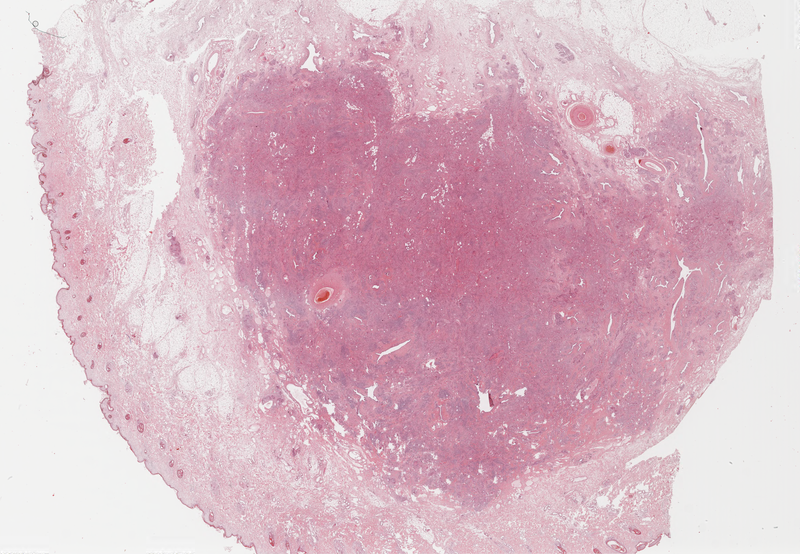

In [3]:
slide.get_thumbnail(size=[800, 800])

This is a snapshot from the SlideRunner tool showing all the annotations

![Alternative text](./sample_anno2.png)

Let us load the annotations for this WSI image from the annotations database. 

In [4]:
slideid = DB.findSlideWithFilename(WSI_filename,'')
DB.loadIntoMemory(slideid)

print(f"{WSI_filename} has {len(DB.annotations.keys())} annotations")

50cf88e9a33df0c0c8f9.svs has 3890 annotations


In [5]:
# Get a few annotations 
anno = list(DB.annotations.keys())[0:5]

In [6]:
import matplotlib.pyplot as plt
import numpy as np

patchSize = 512 

coord_x = DB.annotations[anno[0]].x1
coord_y = DB.annotations[anno[0]].y1

lu_x = int(coord_x - int(patchSize/2))
lu_y = int(coord_y - int(patchSize/2))

lu = (lu_x, lu_y)
img = np.array(slide.read_region(location=(lu_x, lu_y), level=0, size=(patchSize, patchSize)))[:,:,0:4]


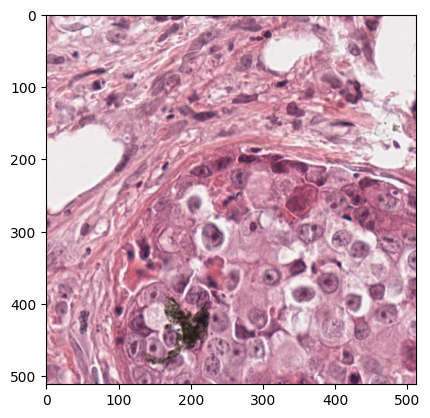

In [7]:
plt.imshow(img)

In [8]:
from SlideRunner.dataAccess.annotations import ViewingProfile
DB.annotations[anno[0]].draw(image=img, leftUpper=lu, zoomLevel=1., thickness=2, vp=ViewingProfile())

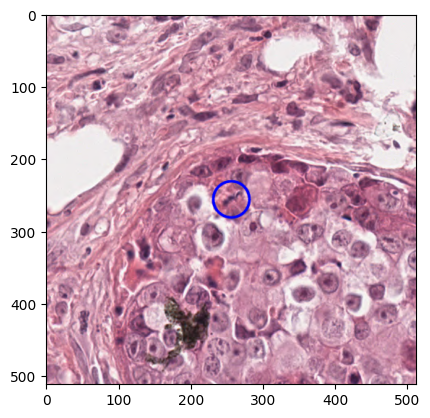

In [9]:
plt.imshow(img)

These annotations are called "spot" annotations and have absolute center coordinates (x,y) with a radius. Let us consider all the annotations for this WSI image. 

In [10]:
from SlideRunner.dataAccess.annotations import *
annoList = []
count = 0
for k in DB.annotations.keys():
    anno = DB.annotations[k]
    if anno.deleted or anno.annotationType != AnnotationType.SPOT:
        continue
    annoList.append([anno.x1, anno.y1, anno.r])
    count += 1

print(f"Total annotations = {len(DB.annotations.keys())}; Spot annotations = {count}")




Total annotations = 3890; Spot annotations = 3889


There is 1 polygon annotation. What is the radius of the spot annotation?

In [11]:
import pandas as pd
df = pd.DataFrame(annoList, columns = ['x', 'y', 'r'])
df['r'].describe()

count    3889.0
mean       25.0
std         0.0
min        25.0
25%        25.0
50%        25.0
75%        25.0
max        25.0
Name: r, dtype: float64

All spot annotations have a radius of 25. 

Questions: 
* How are the circular Spot annotations provided as input to the RetinaNet detector? Quadratic bounding box?
* Clearly it is not possible to provide the entire WSI to the detector. Do we input tiles? How big are these inputs?


The following code is adapted from the get_slides() function used in RetinaNet-CMC-CODAEL.ipynb. It is used to extract the labels and bounding boxes of objects to be detected. 

In [20]:
level = 0 #slide.level_count - 1
level_dimension = slide.level_dimensions[level]
down_factor = slide.level_downsamples[level]

labels, bboxes = [], []
annotations = dict()
positive_class = 1
negative_class = 7
classes = {positive_class: 1}

for id, annotation in DB.annotations.items():
    if annotation.deleted or annotation.annotationType != AnnotationType.SPOT:
        continue
    
    annotation.r = 25
    d = 2 * annotation.r / down_factor
    x_min = (annotation.x1 - annotation.r) / down_factor
    y_min = (annotation.y1 - annotation.r) / down_factor
    x_max = x_min + d
    y_max = y_min + d
    if annotation.agreedClass not in annotations:
        annotations[annotation.agreedClass] = dict()
        annotations[annotation.agreedClass]['bboxes'] = list()
        annotations[annotation.agreedClass]['label'] = list()
    
    annotations[annotation.agreedClass]['bboxes'].append([int(x_min), int(y_min), int(x_max), int(y_max)])
    annotations[annotation.agreedClass]['label'].append(annotation.agreedClass)
    
    if annotation.agreedClass in classes:
        label = classes[annotation.agreedClass]
        bboxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
        labels.append(label)


From the above code, it is clear that the bounding box is square (quadratic) with size, d=50. 

In [21]:
print(f"#Annotations for class 1: {len(annotations[1]['bboxes'])}")
print(f"#Annotations for class 2: {len(annotations[2]['bboxes'])}")
print(f"Total no. of annotations from database: {len(DB.annotations.keys())}")

#Annotations for class 1: 2546
#Annotations for class 2: 1343
Total no. of annotations from database: 3890


Looks like Class 1: Nonmitosis and Class 2: Mitosis - see sampling_func() below.

In [22]:
def sampling_func(y, **kwargs):
    y_label = np.array(y[1])
    h, w = kwargs['size']

    _arbitrary_prob = 0.1
    _mit_prob = 0.5
    
    sample_prob = np.array([_arbitrary_prob, 1-_arbitrary_prob-_mit_prob, _mit_prob])
    
    case = np.random.choice(3, p=sample_prob)
    
    
    
    bg_label = [0] if y_label.dtype == np.int64 else ["bg"]
    classes = bg_label + kwargs['classes']
    level_dimensions = kwargs['level_dimensions']
    level = kwargs['level']
    if ('bg_label_prob' in kwargs):
        _bg_label_prob = kwargs['bg_label_prob']
        if (_bg_label_prob>1.0):
            raise ValueError('Probability needs to be <= 1.0.')
    else:
        _bg_label_prob = 0.0  # add a backgound label to sample complete random
    
    if ('strategy' in kwargs):
        _strategy = kwargs['strategy']
    else:
        _strategy = 'normal'
        
    if ('set' in kwargs):
        _set = kwargs['set']
    else:
        _set = 'training'

    if ('negative_class' in kwargs):
        _negative_class = kwargs['negative_class']
    else:
        _negative_class = 7 # hard examples

        
    _random_offset_scale = 0.5  # up to 50% offset to left and right of frame
    xoffset = randint(-w, w) * _random_offset_scale
    yoffset = randint(-h, h) * _random_offset_scale
    coords = np.array(y[0])

    slide_width, slide_height = level_dimensions[level]
    
    if (case==0):
        if (_set == 'training'): # sample on upper part of image
            xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), int(slide_height/2) - h)
        elif (_set == 'validation'): # sample on lower part of image
            xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), int(slide_height/2) - h) + int(slide_height/2)
        elif (_set == 'test'):
            xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), slide_height - h)
    if (case==2): # mitosis
        
        ids = y_label == 1

        if (_set == 'training'):
            ids[coords[:,1]>slide_height/2] = 0 # lower part not allowed
        elif (_set == 'validation'):
            ids[coords[:,1]<slide_height/2] = 0 # upper part not allowed

        if (np.count_nonzero(ids)<1):
            if (_set == 'training'): # sample on upper part of image
                xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), int(slide_height/2) - h)
            elif (_set == 'validation'): # sample on lower part of image
                xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), int(slide_height/2) - h) + int(slide_height/2)
        else:
            xmin, ymin, xmax, ymax = np.array(y[0])[ids][randint(0, np.count_nonzero(ids) - 1)]
    if (case==1): #nonmitosis
            annos = kwargs['annotations']
            coords = np.array(annos[_negative_class]['bboxes'])
            
            ids = np.arange(len(coords))

            if (_set == 'training'):
                ids[coords[:,1]>slide_height/2] = 0 # lower part not allowed
            elif (_set == 'validation'):
                ids[coords[:,1]<slide_height/2] = 0 # upper part not allowed

            if (np.count_nonzero(ids)<1):

                if (_set == 'training'): # sample on upper part of image
                    xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), int(slide_height/2) - h)
                elif (_set == 'validation'): # sample on lower part of image
                    xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), int(slide_height/2) - h) + int(slide_height/2)
            else:
                xmin, ymin, xmax, ymax = coords[ids][randint(0, np.count_nonzero(ids) - 1)]
        
    return int(xmin - w / 2 + xoffset), int(ymin - h / 2 +yoffset)


In [27]:
from data_loader import *
slide_path = 'WSI/' + WSI_filename
size = 512
files = list()
lbl_bbox = list()
train_slides=list()
val_slides=list()

if len(bboxes) > 0:
    lbl_bbox.append([bboxes, labels])
    files.append(SlideContainer(file=slide_path, annotations=annotations,level=level, width=size, height=size, y=[bboxes, labels], sample_func=partial(sampling_func, set='training', negative_class=negative_class)))
    train_slides.append(len(files)-1)
    lbl_bbox.append([bboxes, labels])
    files.append(SlideContainer(file=slide_path, annotations=annotations, level=level, width=size, height=size, y=[bboxes, labels], sample_func=partial(sampling_func, set='validation', negative_class=negative_class)))
    val_slides.append(len(files)-1)

In [24]:
files

In [34]:
bs = 12
train_images = 5000
val_images = 5000

train_files = list(np.random.choice([files[x] for x in train_slides], train_images))
valid_files = list(np.random.choice([files[x] for x in val_slides], val_images))


In [35]:
path = Path('./')
train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)

img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]



/var/folders/08/xq5mk3gs3m3dn4xzcc2jln0m0000gn/T/ipykernel_41832/2646122755.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  img2bbox = dict(zip(files, np.array(lbl_bbox)))


In [36]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )


In [37]:
item_list = ItemLists(path, train, valid)

lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min).normalize()

/Users/nirmala/anaconda3/envs/capstone/lib/python3.9/site-packages/fastai/basic_data.py:262: UserWarning: There seems to be something wrong with your dataset, for example, in the first batch can't access any element of self.train_ds.
Tried: 4520,4310,3815,3683,2554...
  warn(warn_msg)


You can deactivate this warning by passing `no_check=True`.


KeyError: 7

Reference: 
1. https://github.com/DeepPathology/SlideRunner/blob/master/SlideRunner/doc/DemoWorkflow_WorkingWithSlideRunnerDatabases.ipynb
